# 1. 导入相关的库

In [1]:
import libpysal as ps
import numpy as np
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error
import geopandas as gp
import matplotlib.pyplot as plt
from GeoEL.model import GWXGBoost
from GeoEL.select_bandwidth import SelectBandwidth
%matplotlib inline

# 2. 加载并处理Georgia数据集

In [2]:
# 2.1 加载Georgia数据集
data = ps.io.open(ps.examples.get_path('GData_utm.csv'))
coords = np.array(list(zip(data.by_col('X'), data.by_col('Y'))))
Y = np.array(data.by_col('PctBach')).reshape(-1, 1)
rural = np.array(data.by_col('PctRural')).reshape((-1, 1))
pov = np.array(data.by_col('PctPov')).reshape((-1, 1))
african_amer = np.array(data.by_col('PctBlack')).reshape((-1, 1))
feature_names = ['PctRural', 'PctPov', 'PctBlack']
X = np.hstack([rural, pov, african_amer])

In [3]:
# 2.2 将数据进行打乱与划分
np.random.seed(908)
sample = np.random.choice(range(159), 10)
mask = np.ones_like(Y, dtype=bool).flatten()
mask[sample] = False
cal_coords = coords[mask]
cal_y = Y[mask]
cal_X = X[mask]

need_pred_coords = coords[~mask]
need_pred_y = Y[~mask]
need_pred_X = X[~mask]

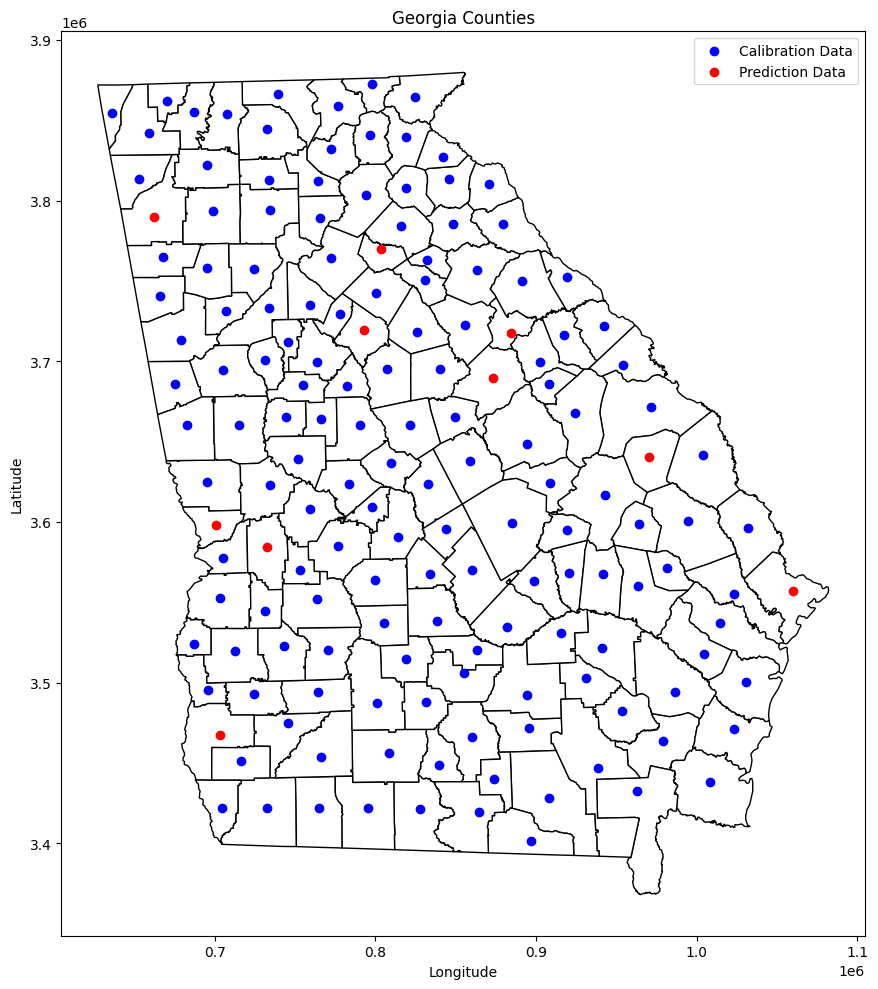

In [4]:
# 2.3 将处理后的数据进行画图展示，将cal_y和pred_y进行不同颜色的展示
georgia_shp = gp.read_file(ps.examples.get_path('G_utm.shp'))
fig, ax = plt.subplots(figsize=(10, 10))
georgia_shp.plot(ax=ax, edgecolor='black', facecolor='white')
cal_sc = ax.scatter([coord[0] for coord in cal_coords], [coord[1] for coord in cal_coords], c='blue', label='Calibration Data')
pred_sc = ax.scatter([coord[0] for coord in need_pred_coords], [coord[1] for coord in need_pred_coords], c='red', label='Prediction Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Georgia Counties')
plt.legend()
plt.tight_layout()
plt.show()

# 3.最优带宽选择

In [5]:
# 带宽选择
bw = SelectBandwidth(coords=cal_coords, feature=cal_X, target=cal_y.reshape(-1), model_type='XGBoost', n_estimators=10, max_depth=3, kernel='bisquare', criterion='mse', fixed=False, spherical=False, n_jobs=4,random_state=1).search(verbose=True)
print("最优带宽为：", bw)

Searching for bandwidth...
Bandwidth:  85.0 , score:  18.39
Bandwidth:  110.0 , score:  18.59
Bandwidth:  70.0 , score:  19.82
Bandwidth:  95.0 , score:  19.02
Bandwidth:  80.0 , score:  20.04
Bandwidth:  89.0 , score:  18.94
Bandwidth:  83.0 , score:  18.38
Bandwidth:  82.0 , score:  19.99
Bandwidth:  84.0 , score:  18.27
最优带宽为： 84.0


# 4.模型的初始化与训练以及模型的评估

In [6]:
# 4.1 利用最优带宽进行模型初始化与训练,以及模型的评估
gwModel = GWXGBoost(coords=cal_coords, feature=cal_X, target=cal_y.reshape(-1), n_estimators=10, max_depth=3, bandwidth=84.0, kernel='bisquare', fixed=False, spherical=False, n_jobs=4, random_state=1, feature_names=feature_names)
gwModel.fit()
model_cal_y = gwModel.predict(pred_coords=cal_coords,pred_x=cal_X)
print("模型的拟合的R2值为：", r2_score(model_cal_y, cal_y.reshape(-1)))
print("模型的拟合的解释方差为：", explained_variance_score(model_cal_y, cal_y.reshape(-1)))
print("模型的拟合的均方误差为：", mean_squared_error(model_cal_y, cal_y.reshape(-1)))

模型的拟合的R2值为： 0.796417767416896
模型的拟合的解释方差为： 0.8044247611531395
模型的拟合的均方误差为： 4.064259634932868


In [7]:
# 4.2 利用模型进行预测
model_pred_y = gwModel.predict(pred_coords=need_pred_coords, pred_x=need_pred_X)
print("模型的预测误差为：", mean_squared_error(need_pred_y, model_pred_y))
print("原始的数据值为：", need_pred_y.reshape(-1))
print("模型的预测值为：", np.round(model_pred_y, 1).reshape(-1))
print("相关系数为：", np.corrcoef(need_pred_y.flatten(), model_pred_y.flatten())[0][1])


模型的预测误差为： 6.197722119891891
原始的数据值为： [ 9.2 18.6  9.4 13.7  6.8  7.7  4.6 16.6  9.5  5.6]
模型的预测值为： [ 9.8 16.2  7.9 10.9  6.2 10.7  7.3 22.   9.5  5.8]
相关系数为： 0.8600561760762689


# 5.模型的可解释性分析

{'PctRural': 14.0, 'PctPov': 16.0, 'PctBlack': 11.0}


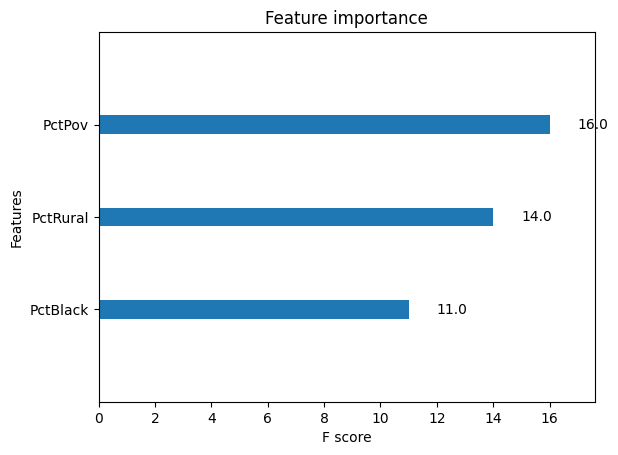

In [8]:
# 5.1 得到第2个局部拟合模拟的特征重要性
local_feature_importance = gwModel.get_local_feature_importance(model_index=1)
print(local_feature_importance)
#画图展示
gwModel.plot_local_feature_importance(model_index=1)

{'PctRural': 16.76, 'PctPov': 16.84, 'PctBlack': 9.01}


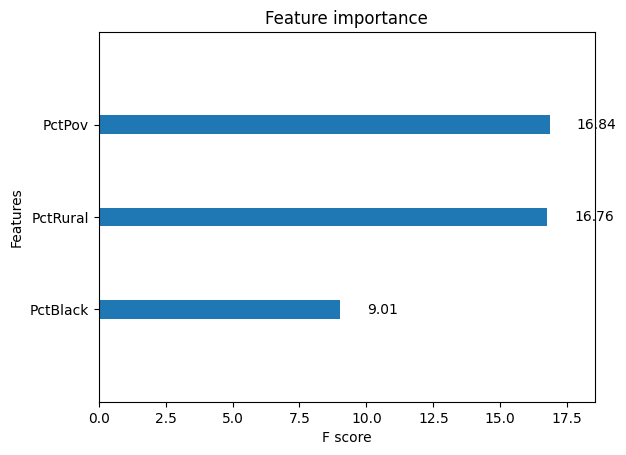

In [9]:
# 5.2 得到全局模型的特征重要性
global_feature_importance = gwModel.get_global_feature_importance()
print(global_feature_importance)
# 画图展示
gwModel.plot_global_feature_importance()

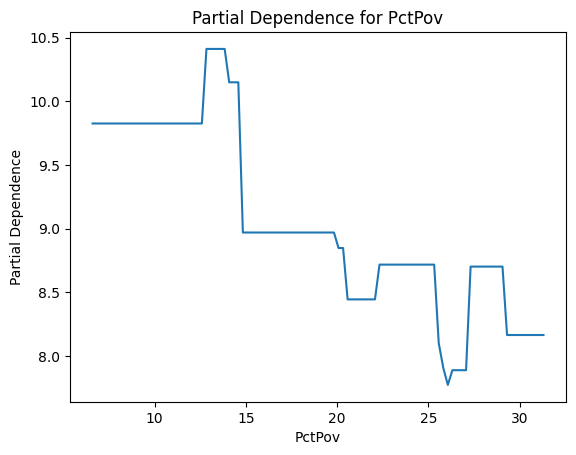

In [10]:
# 5.3 画出第2个局部模型关于特征PctPov的偏依赖性
gwModel.plot_local_partial_dependence(model_index=1, feature_index=[1])

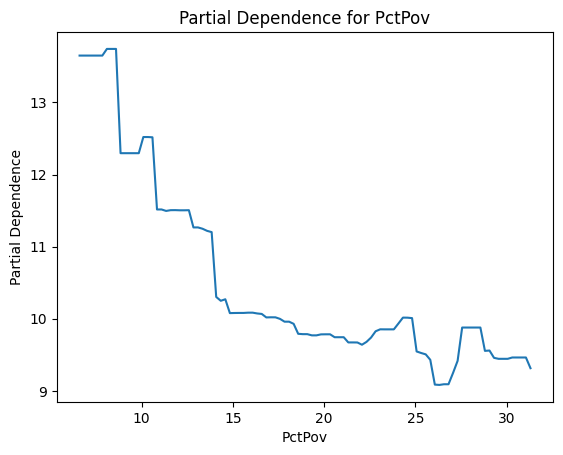

In [11]:
# 5.4 画出全局模型关于特征PctPov的偏依赖性
gwModel.plot_global_partial_dependence(feature_index=[1])